In [29]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [30]:
class Net(nn.Module):
  def __init__(self, num_channels):
    super(Net,self).__init__()
    
    self.num_channels = num_channels
    
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)
    
  def forward(self,x):
      #Empieza 3x64x64
      x = self.conv1(x) # num_channels x 64 x 64
      x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
      x = self.conv2(x) # num_channels*2 x 32 x32
      x = F.relu(F.max_pool2d(x, 2)) #num_channels*2 x 16 x 16
      x = self.conv3(x) # num_channels*4 x16x16
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8

      #flatten
      x = x.view(-1, self.num_channels*4*8*8)

      #fc
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      #log_softmax

      x = F.log_softmax(x, dim=1)

      return x             


      


In [3]:
%ls '/content/drive/MyDrive/dl-pytorch/datasets/64x64_SIGNS'

test_signs/  train_signs/  val_signs/


In [4]:
import sys

In [5]:
sys.path.append('/content/drive/MyDrive/dl-pytorch/')

In [6]:
from plot_helpers import imshow

In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SIGNSDataset(Dataset):
  def __init__(self,base_dir,split='train',transform=None):
    path = os.path.join(base_dir,'{}_signs'.format(split))
    files = os.listdir(path)

    self.filenames = [os.path.join(path,f) for f in files if f.endswith(".jpg")]

    self.targets = [int(f[0]) for f in files]
    self.transform = transform

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self,idx):
    image = Image.open(self.filenames[idx])
    if self.transform :
      image = self.transform(image)
    return image, self.targets[idx]

In [8]:
signs = SIGNSDataset('/content/drive/MyDrive/dl-pytorch/datasets/64x64_SIGNS', split='train')

In [9]:
len(signs)

864

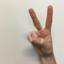

In [10]:
signs[0][0]

In [11]:
import torchvision.transforms as transforms

In [12]:
trainset = SIGNSDataset('/content/drive/MyDrive/dl-pytorch/datasets/64x64_SIGNS', split='train', transform=transforms.ToTensor())

In [13]:
dataloader = DataLoader(trainset, batch_size=32)

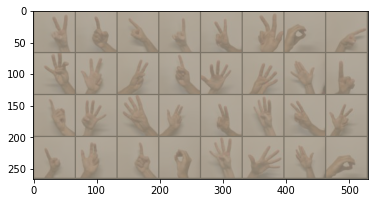

tensor([2, 1, 1, 1, 2, 3, 0, 1, 4, 3, 2, 1, 5, 4, 5, 1, 1, 4, 4, 3, 2, 4, 2, 3,
        1, 3, 1, 0, 4, 5, 5, 0])


In [14]:
from torchvision.utils import make_grid
for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

In [15]:
import torch.optim as optim


In [16]:
device = torch.device('cuda')

In [31]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum = 0.9)

In [23]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0

  def update(self, val, size):
    self.S += val
    self.N += size
  
  def __call__(self):
    return self.S/float(self.N)

In [24]:
num_epochs = 100

In [32]:
for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-'*10)

  running_loss = RunningMetric() # perdida
  running_acc = RunningMetric() #precision

  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    
    outputs = net(inputs)
    _, preds = torch.max(outputs,1)
    loss = loss_fn(outputs, targets)
    
    loss.backward() #magias: gradientes calculados automaticamente
    optimizer.step() #magia2: actualiza las perillas o los parametros
    
    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size,
                       batch_size)
    running_acc.update(torch.sum(preds == targets).float(),
                       batch_size)
  print("Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                          running_acc()))

Epoch 1/100
----------
Loss: 1.7926 Acc: 0.1435 
Epoch 2/100
----------
Loss: 1.7920 Acc: 0.1435 
Epoch 3/100
----------
Loss: 1.7915 Acc: 0.1586 
Epoch 4/100
----------
Loss: 1.7911 Acc: 0.1748 
Epoch 5/100
----------
Loss: 1.7908 Acc: 0.1759 
Epoch 6/100
----------
Loss: 1.7905 Acc: 0.1725 
Epoch 7/100
----------
Loss: 1.7902 Acc: 0.1725 
Epoch 8/100
----------
Loss: 1.7899 Acc: 0.1725 
Epoch 9/100
----------
Loss: 1.7896 Acc: 0.1725 
Epoch 10/100
----------
Loss: 1.7892 Acc: 0.1725 
Epoch 11/100
----------
Loss: 1.7889 Acc: 0.1725 
Epoch 12/100
----------
Loss: 1.7886 Acc: 0.1725 
Epoch 13/100
----------
Loss: 1.7882 Acc: 0.1725 
Epoch 14/100
----------
Loss: 1.7878 Acc: 0.1725 
Epoch 15/100
----------
Loss: 1.7873 Acc: 0.1725 
Epoch 16/100
----------
Loss: 1.7868 Acc: 0.1725 
Epoch 17/100
----------
Loss: 1.7863 Acc: 0.1725 
Epoch 18/100
----------
Loss: 1.7857 Acc: 0.1829 
Epoch 19/100
----------
Loss: 1.7851 Acc: 0.1956 
Epoch 20/100
----------
Loss: 1.7843 Acc: 0.2049 
Epoch 21/